In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, shutil
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras import applications, regularizers, callbacks
from keras import optimizers, layers, models, preprocessing


### Data Preparation

In [2]:
train_dir = 'train_dataset'
labels_file = 'training_model/labels.csv'
labels_df = pd.read_csv(labels_file)


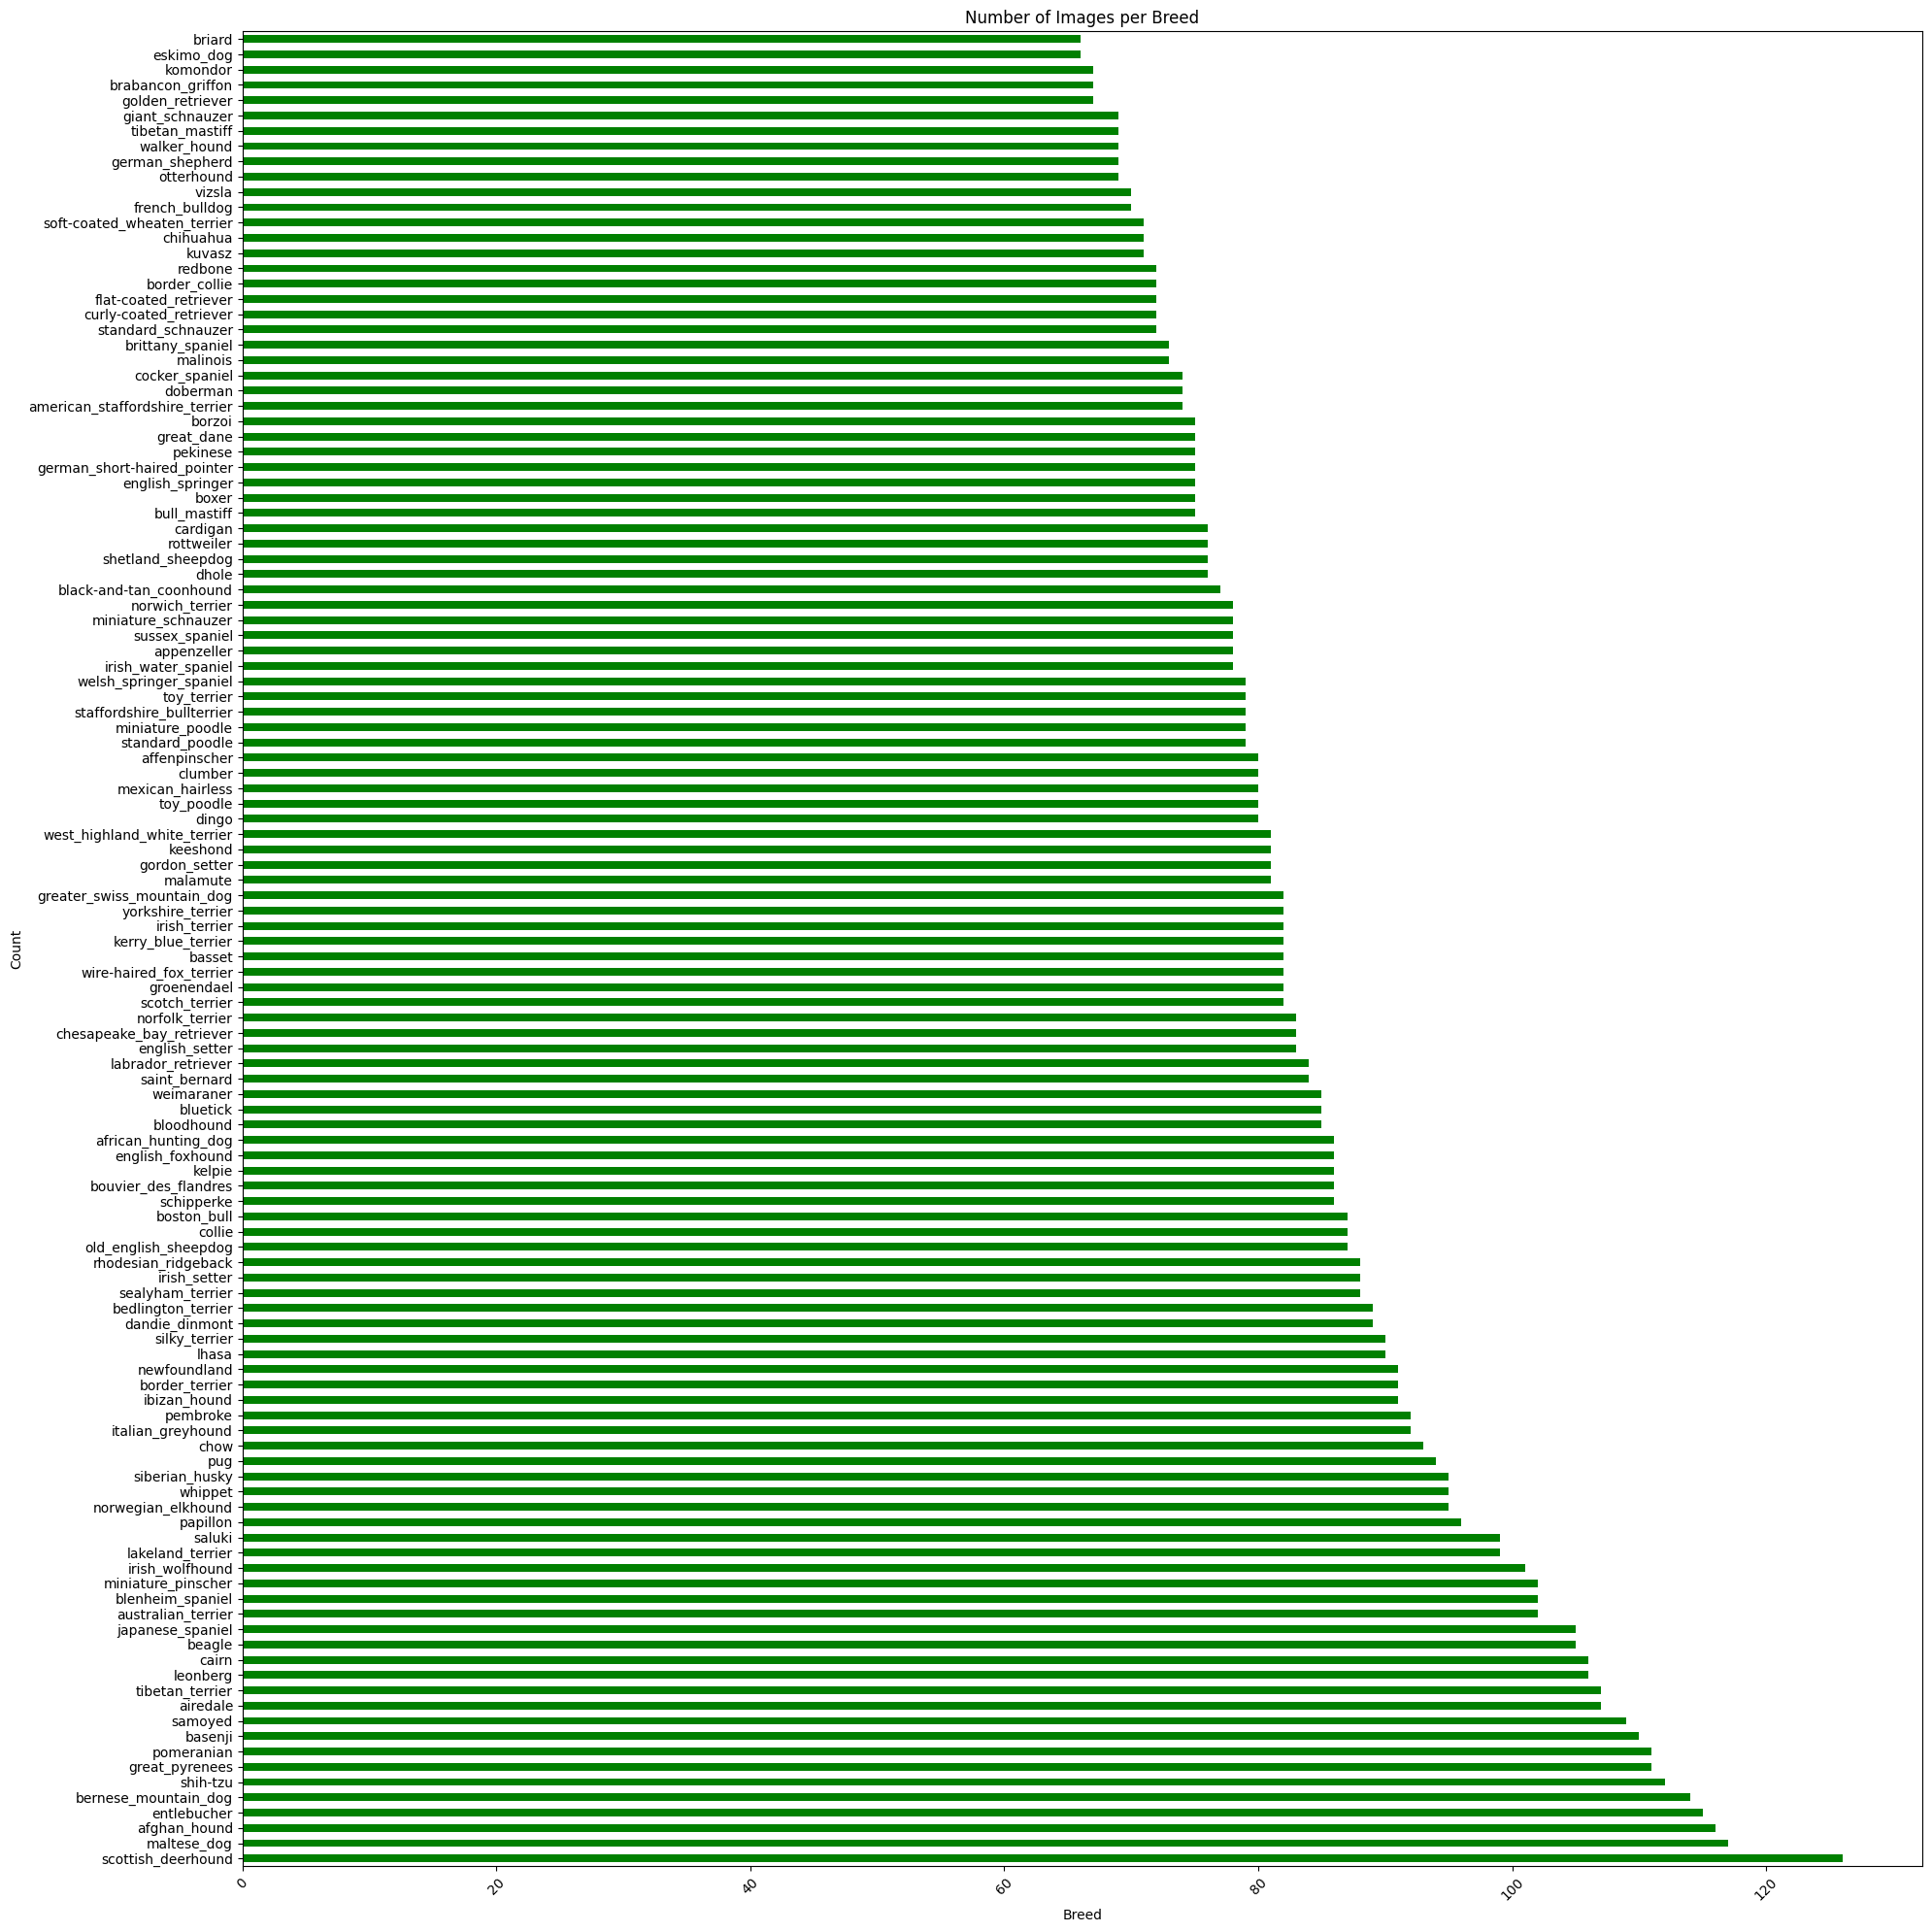

In [3]:
# Count the number of images per breed
breed_counts = labels_df['breed'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(20, 20))
breed_counts.plot(kind='barh',color='g')
plt.title('Number of Images per Breed')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Select all unique breeds
breeds = labels_df['breed'].unique()

# divide the dataset into groups of 100 images for each breed
filtered_labels_df = labels_df.groupby('breed', group_keys=False).apply(lambda x: x.head(10)).reset_index(drop=True)
labels_df = labels_df[~labels_df['id'].isin(filtered_labels_df['id'])]

filtered_labels_df['id'] = filtered_labels_df['id'] + '.jpg'

In [5]:
# Create a directory for filtered images (in a temporary location)
filtered_images_dir = 'working/filtered_images'
os.makedirs(filtered_images_dir, exist_ok=True)

# Copy the filtered images to the new directory
for img_name in filtered_labels_df['id']:
    src = os.path.join(train_dir, img_name)
    dst = os.path.join(filtered_images_dir, img_name)
    shutil.copyfile(src, dst)

### CNN Model Build

In [6]:
# Encode the labels
filtered_labels_df['breed'] = filtered_labels_df['breed'].astype('category')
filtered_labels_df['breed_code'] = filtered_labels_df['breed'].cat.codes
num_classes = filtered_labels_df['breed_code'].nunique()

# Split the data into training and validation sets
train_df, val_df = train_test_split(
    filtered_labels_df, 
    test_size=0.2, 
    stratify=filtered_labels_df['breed_code'],
    random_state=42
)

In [7]:
# Setting up ImageDataGenerator for Training and Validation
# Resize and normalize images with additional data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Add validation split here
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split here

In [8]:
# Load and preprocess images with smaller target size and batch size
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='training',  
    batch_size=16,  
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='validation',  
    batch_size=16,  
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  
)

Found 640 validated image filenames belonging to 10 classes.
Found 40 validated image filenames belonging to 10 classes.


In [9]:
# Loading Pre-trained Model and Adding Custom Layers
base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# print summary of base model
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
# Add custom layers on top with dropout and L2 regularization
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Increased L2 regularization
x = layers.BatchNormalization()(x)  # Add batch normalization layer
x = layers.Dropout(0.5)(x)  # Add another dropout layer
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = models.Model(inputs=base_model.input, outputs=predictions)

### Model Train

In [11]:
# # Unfreeze more layers of the base model
for layer in base_model.layers[-40:]:
    layer.trainable = True


# Compile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping, learning rate scheduler, and model checkpointing
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', save_best_only=False, monitor='val_loss', mode='min')

# Train the model with early stopping, learning rate scheduler, and checkpointing
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - accuracy: 0.1396 - loss: 14.6832 - val_accuracy: 0.6000 - val_loss: 12.5996 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.4016 - loss: 13.2565 - val_accuracy: 0.7500 - val_loss: 12.0541 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5717 - loss: 12.5154 - val_accuracy: 0.7000 - val_loss: 12.0503 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.6347 - loss: 12.2057 - val_accuracy: 0.7000 - val_loss: 11.9827 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.6889 - loss: 11.8518 - val_accuracy: 0.7500 - val_loss: 11.7150 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7754 - loss: 11.5546 - val_accuracy: 0.7750 - val_loss: 11.5932 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms

### Evaluation

In [12]:
# Evaluate the model
evaluation = model.evaluate(val_generator)
print(f'Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8031 - loss: 10.1956
Validation Loss: 10.225740432739258, Validation Accuracy: 0.824999988079071


<Axes: title={'center': 'Accuracy'}>

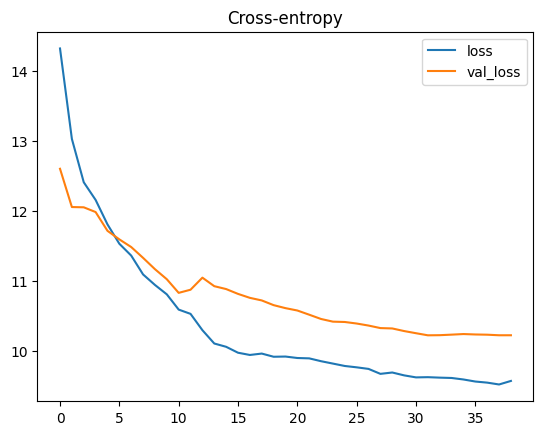

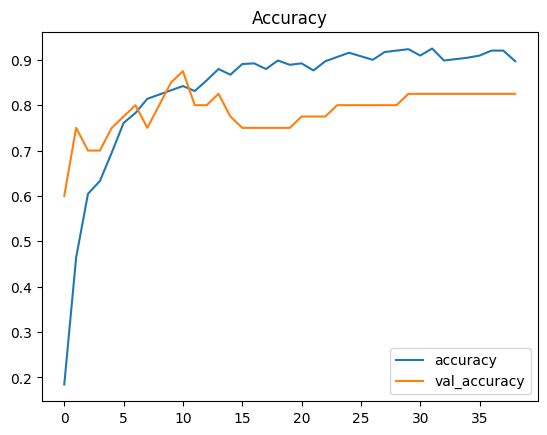

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0


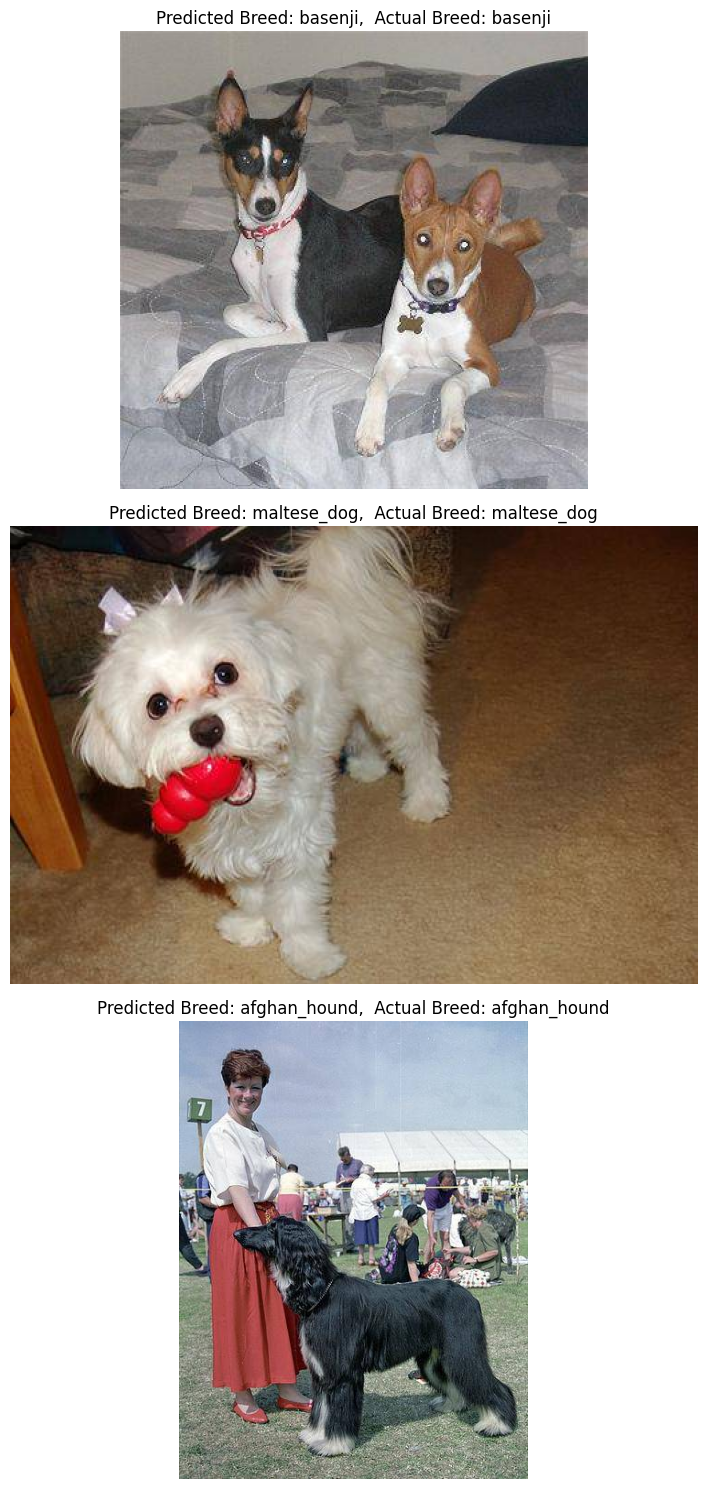

In [15]:
# Function to load the image without resizing
def load_original_image(img_path):
    img = preprocessing.image.load_img(img_path)
    return img

# Function to preprocess the image (resizing and normalization)
def preprocess_image(img_path, target_size):
    img = preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img, img_array

# Assuming your model input size is 128x128
target_size = (128, 128)

image_dir = '/Users/dilaraorazmetova/projects/dog_breed_classificator/train_dataset/'
# Paths to the images you want to predict

image_ids = [
    '04b5834c3a969c6308ce157c547bb313.jpg',
    '113ef2bb9e14d89f927314f73d573313.jpg',
    '571778b4ab5037907c5fe7d6f3d56b52.jpg',
]

image_paths = [f'{image_dir}{image_id}' for image_id in image_ids]

# Actual breed names corresponding to the images

actual_breeds = []
for image_id in image_ids:
    actual_breeds.append(filtered_labels_df.loc[filtered_labels_df['id'] == image_id, 'breed'].item())

# Map the predicted class index to the corresponding breed
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}  # Reverse the dictionary


# Plot each image on a separate line with predicted breed
plt.figure(figsize=(10, 5 * len(image_paths)))
# model = models.load_model('/Users/dilaraorazmetova/projects/dog_breed_classificator/best_model.keras')

for i, (img_path, actual_breed) in enumerate(zip(image_paths, actual_breeds), 1):
    # Load the original image without resizing
    original_img = load_original_image(img_path)
    img, img_array = preprocess_image(img_path, target_size)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    print(predicted_class)
    predicted_breed = class_indices[predicted_class]
    plt.subplot(len(image_paths), 1, i)
    plt.imshow(original_img)
    plt.title(f'Predicted Breed: {predicted_breed},  Actual Breed: {actual_breed}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
model.save('best_model.keras')